In [1]:
import os
from glob import glob
import numpy as np
#import dask
from dask.delayed import delayed
import dask.array as da
import xarray as xr
#import xrft
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

#from mitequinox.utils import *

#root_dir = '/home1/datawork/xyu/Drifters/'
root_dir = '/Users/aponte/data/drifters/'
data_dir = root_dir+'drifter_data_v1.02/'

In [2]:
#from dask_jobqueue import PBSCluster
#local_dir = os.getenv('TMPDIR')
#cluster = PBSCluster(local_directory=local_dir)
#w = cluster.start_workers(5)
#print(cluster.job_script())

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
#client = Client(cluster)
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:61327 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [19]:
client.close()

---


# 1. Drifter

## （ a. all drifters, b. drogued drifters, c. undrogued drifters）--> including Argos and GPS

In [16]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%


#drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
#list(drifter_dataset.items())

dr = h5py.File(data_dir+'Drifter_dataset_processing.mat','r') 
list(dr.items())

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v)                            157978*1440
# dpth2:                                 157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157985, 1440), type "<f8">),
 ('dr2', <HDF5 dataset "dr2": shape (157985, 1440), type "<f8">),
 ('lat2', <HDF5 dataset "lat2": shape (157985, 1440), type "<f8">),
 ('lon2', <HDF5 dataset "lon2": shape (157985, 1440), type "<f8">),
 ('time2', <HDF5 dataset "time2": shape (157985, 1440), type "<f8">),
 ('uv2', <HDF5 dataset "uv2": shape (157985, 1440), type "|V16">)]

In [17]:
N = dr['lat2'].shape[0]
chunk = 1000

In [18]:
def load_variable(vname, i, dims, j):
    dr = h5py.File(data_dir+'Drifter_dataset_processing.mat','r')
    if len(dims)==2:
        if j is None:
            var = dr[vname][i:i+chunk,:].view(np.double).reshape(chunk,1440,-1)[:].squeeze()
        else:
            var = dr[vname][i:i+chunk,:].view(np.double).reshape(chunk,1440,-1)[:,:,j]
    else:
        var = dr[vname][i:i+chunk][:].squeeze()
    return var

load_lazy = delayed(load_variable, pure=True)

_vdict = {'lat': 'lat2', 'lon': 'lon2', 'u': 'uv2', 'v': 'uv2' , 
          'depth': 'dpth2', 'time': 'time2'}

def load_xr_variable(vname):
        
    j=None
        
    if vname in ['u', 'v']:
        dims = ['index','hours']
        if vname == 'u':
            j=0
        elif vname == 'v':
            j=1        
    elif vname in ['lon', 'lat', 'time','depth']:
        dims = ['index','hours']
    else:
        dims = ['index',]
        
    lazy_variable = [load_lazy(_vdict[vname], i, dims, j) for i in np.arange(0,N-chunk,chunk)]
    
    sample = lazy_variable[0].compute()  # load the first value
    
    arrays = [da.from_delayed(v,                # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
              for v in lazy_variable]
    
    stack = da.concatenate(arrays, axis=0)  # Stack all small Dask arrays into one
    
    return xr.Variable(dims, stack)

In [19]:
#ds = xr.Dataset({**{v: load_xr_variable(v) for v in ['lat','lon']},
#                 **{v: load_xr_variable(v) for v in ['u','v']}})
ds = xr.Dataset({v: load_xr_variable(v) for v in ['lat', 'lon', 'u', 'v', 'depth', 'time']})
#ds = xr.Dataset({v: load_xr_variable(v) for v in ['lat', 'lon', 'time']})
#ds = xr.Dataset({v: load_xr_variable(v) for v in ['lat', 'lon', 'time']})

In [14]:
# necessary?
ds.to_zarr('drifter.zarr', mode='w')

---

In [20]:
ds

<xarray.Dataset>
Dimensions:  (hours: 1440, index: 157000)
Dimensions without coordinates: hours, index
Data variables:
    lat      (index, hours) float64 dask.array<shape=(157000, 1440), chunksize=(1000, 1440)>
    lon      (index, hours) float64 dask.array<shape=(157000, 1440), chunksize=(1000, 1440)>
    u        (index, hours) float64 dask.array<shape=(157000, 1440), chunksize=(1000, 1440)>
    v        (index, hours) float64 dask.array<shape=(157000, 1440), chunksize=(1000, 1440)>
    depth    (index, hours) float64 dask.array<shape=(157000, 1440), chunksize=(1000, 1440)>
    time     (index, hours) float64 dask.array<shape=(157000, 1440), chunksize=(1000, 1440)>

In [29]:
xr.merge([ds.isel(hours=0).rename({v: v+'_start' for v in ds}),
          ds.isel(hours=-1).rename({v: v+'_end' for v in ds}),
          ds.mean('hours')
         ]).to_zarr('drifter_bulk.zarr', mode='w')
#ds.mean('hours').to_zarr('drifter_mean.zarr', mode='w')

---

In [53]:
ds0 = xr.open_zarr('drifter_bulk.zarr')
ds0 = ds0.drop(['u','v','depth', 
                'u_start','v_start','depth_start', 
                'u_end','v_end','depth_end'])
print(ds0)

<xarray.Dataset>
Dimensions:     (index: 157000)
Dimensions without coordinates: index
Data variables:
    lat         (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lat_end     (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lat_start   (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lon         (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lon_end     (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lon_start   (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    time        (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    time_end    (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    time_start  (index) float64 dask.array<shape=(157000,), chunksize=(1000,)>


In [54]:
#dir(ds0.time)
ds0.time.shift?

Signature: ds0.time.shift(shifts=None, fill_value=<NA>, **shifts_kwargs)
Docstring:
Shift this array by an offset along one or more dimensions.

Only the data is moved; coordinates stay in place. Values shifted from
beyond array bounds are replaced by NaN. This is consistent with the
behavior of ``shift`` in pandas.

Parameters
----------
shifts : Mapping with the form of {dim: offset}
    Integer offset to shift along each of the given dimensions.
    Positive offsets shift to the right; negative offsets shift to the
    left.
fill_value: scalar, optional
    Value to use for newly missing values
**shifts_kwargs:
    The keyword arguments form of ``shifts``.
    One of shifts or shifts_kwarg must be provided.

Returns
-------
shifted : DataArray
    DataArray with the same coordinates and attributes but shifted
    data.

See also
--------
roll

Examples
--------

>>> arr = xr.DataArray([5, 6, 7], dims='x')
>>> arr.shift(x=1)
<xarray.DataArray (x: 3)>
array([ nan,   5.,   6.])
Coordin

In [55]:
# get rid of same drifter data
#dt = ds0.time.shift(index=1) - 
#ds0 = ds0.where(())

In [56]:
print(ds0.isel(index=0).lon.values)
print(ds0.isel(index=1).lon.values)
#print(ds0.isel(index=0).lon.values)
print(ds0.isel(index=1).time.values - ds0.isel(index=0).time.values)

307.9927071388889
306.9627223472222
720.0


In [57]:
720./24

30.0

In [58]:
ds1 = ds0.copy()
#ds1 = ds1.chunk({'index': 10})
ds1 = ds1.rename({'index': 'index1'})
for v in ds1:
    ds1 = ds1.rename({v: v+'1'})

In [59]:
ds1

<xarray.Dataset>
Dimensions:      (index1: 157000)
Dimensions without coordinates: index1
Data variables:
    lat1         (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lat_end1     (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lat_start1   (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lon1         (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lon_end1     (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    lon_start1   (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    time1        (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    time_end1    (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>
    time_start1  (index1) float64 dask.array<shape=(157000,), chunksize=(1000,)>

In [60]:
ds = xr.merge([ds0,ds1.isel(index1=slice(100))]) # 100 is imposed by the scheduler
%time ds = ds.stack(index_combo=('index','index1')).chunk({'index_combo': 10000}) # 10000 is imposed by memory
ds

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 7.55 s, sys: 753 ms, total: 8.31 s
Wall time: 8.52 s


<xarray.Dataset>
Dimensions:      (index_combo: 15700000)
Coordinates:
  * index_combo  (index_combo) MultiIndex
  - index        (index_combo) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  - index1       (index_combo) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
Data variables:
    lat          (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    lat_end      (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    lat_start    (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    lon          (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    lon_end      (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    lon_start    (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    time         (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,)>
    time_end     (index_combo) float64 dask.array<shape=(15700000,), chunksize=(10000,

In [61]:
RADIUS_EARTH = 6378.0
deg2rad = np.pi / 180.
def haversine(lon1, lat1, lon2, lat2):
    """Computes the Haversine distance in kilometres between two points
    :param x: first point or points as array, each as array of latitude, longitude in degrees
    :param y: second point or points as array, each as array of latitude, longitude in degrees
    :return: distance between the two points in kilometres
    """
    llat1 = lat1 * deg2rad
    llat2 = lat2 * deg2rad
    llon1 = lon1 * deg2rad
    llon2 = lon2 * deg2rad
    arclen = 2 * np.arcsin(np.sqrt((np.sin((llat2 - llat1) / 2)) ** 2 +
                                   np.cos(llat1) * np.cos(llat2) * (np.sin((llon2 - llon1) / 2)) ** 2))
    return arclen * RADIUS_EARTH

```
    TIME   
           Size:       15230718x1
           Dimensions: TIME
           Datatype:   double
           Attributes:
                       standard_name = 'time'
                       units         = 'hours since 1979-01-01 00:00:00'
```

In [62]:
ds['distance'] = haversine(ds.lon, ds.lat, ds.lon1, ds.lat1).rename('distance')
ds['dt'] = ds.time1 - ds.time
#ds['dt'] = ds.time1 - ds.time

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

(array([3457., 3207., 4052., 3084., 3853., 3070., 3129., 3817., 2876.,
        3640.]),
 array([   0.,  150.,  300.,  450.,  600.,  750.,  900., 1050., 1200.,
        1350., 1500.]),
 <a list of 10 Patch objects>)

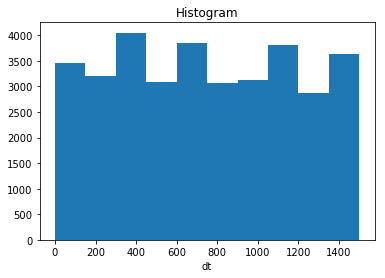

distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)


In [63]:
#ds['distance'].plot.hist()
ds['dt'].plot.hist(range=(0,1500))

In [15]:
lds = ds.where( (ds.distance<300) & (ds.distance>0) & (ds.dt<10) , drop=True)
lds

<xarray.Dataset>
Dimensions:      (index_combo: 13832)
Coordinates:
  * index_combo  (index_combo) MultiIndex
  - index        (index_combo) int64 1 1 2 2 2 2 3 3 ... 20 21 23 24 26 27 28 28
  - index1       (index_combo) int64 0 5 0 1 5 6 0 1 ... 19 20 22 23 25 26 25 26
Data variables:
    lat          (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    lon          (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    time         (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    lat1         (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    lon1         (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    time1        (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    distance     (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>
    dt           (index_combo) float64 dask.array<shape=(13832,), chunksize=(131,)>

(array([4., 0., 5., 0., 2., 0., 4., 0., 0., 1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

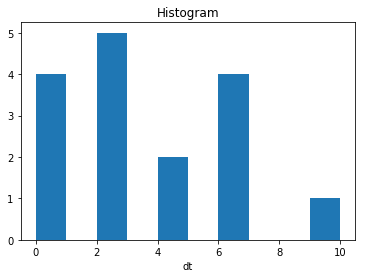

In [13]:
np.abs(lds['dt']/24.).plot.hist(range=(0,10))

In [41]:
lds = lds.persist()

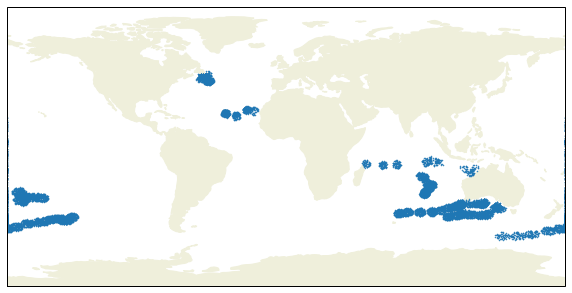

In [61]:
#_projection = ccrs.Robinson(central_longitude=-180)
_projection = ccrs.PlateCarree(0.)
#_projection = ccrs.Miller(central_longitude=-180)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=_projection)
#ax.set_extent(None)
ax.set_global()
ax.plot(lds.lon, lds.lat, '.', markersize=1, transform=ccrs.PlateCarree(0.))
#ax.plot(lds.lon.values, lds.lat.values, '.', markersize=1, transform=ccrs.PlateCarree())
#ax.plot(lds.lon.values.T, lds.lat.values.T, '.', markersize=1, transform=ccrs.PlateCarree())
#ax.plot(lds.lon.values.T, lds.lat.values.T, '.', markersize=1, transform=ccrs.Geodetic())
#ax.plot(lds.lon, lds.lat, '.', markersize=1, transform=ccrs.Geodetic())
#ax.plot(lds.lon, lds.lat, 'k.')
ax.add_feature(cfeature.LAND)

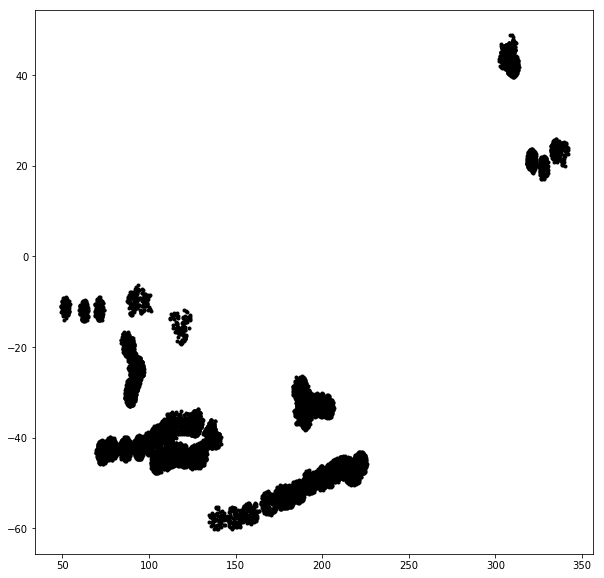

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(lds.lon,lds.lat,'k.')

In [7]:
ds = xr.open_dataset(data_dir+'driftertrajWMLE_1.02_block1.nc')

In [8]:
ds

<xarray.Dataset>
Dimensions:  (TIME: 15230718)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2005-04-15T20:00:00 ... NaT
Data variables:
    ID       (TIME) float64 ...
    LAT      (TIME) float64 ...
    LON      (TIME) float64 ...
    U        (TIME) float64 ...
    V        (TIME) float64 ...
    LAT_ERR  (TIME) float64 ...
    LON_ERR  (TIME) float64 ...
    U_ERR    (TIME) float64 ...
    V_ERR    (TIME) float64 ...
    GAP      (TIME) timedelta64[ns] ...
    RMSGAP   (TIME) timedelta64[ns] ...
    DROGUE   (TIME) float64 ...
Attributes:
    title:        Hourly Argos-tracked drifters location and velocity estimat...
    description:  This is version 1.02, block 1 of the dataset. See http://ww...
    note:         For all variables of dimension TIME, interruptions in the e...
    creator:      Shane Elipot and Rick Lumpkin
    timestamp:    19-Dec-2018 13:25:49

In [9]:
ds.note

'For all variables of dimension TIME, interruptions in the estimation along a single trajectory are indicated by "Inf" values; Individual trajectories are separated by "NaN" values; Thus, one can use the COL2CELL function of the JLAB Matlab toolbox (http://www.jmlilly.net) to convert each data matrix into a cell array with one component for each individual trajectory, without the need to load and loop for individual IDs, e.g. lat = col2cell(lat);'

In [10]:
inan = np.where(np.isnan(ds.LAT.values))[0]

In [11]:
import dask.bag as db
#import json

In [12]:
#b = db.from_sequence(['1.dat', '2.dat', ...]).map(load_from_filename)
def load_trajectory(ij):
    ds = xr.open_dataset(data_dir+'driftertrajWMLE_1.02_block1.nc')
    return ds.isel(TIME=slice(ij[0],ij[1]))
b = db.from_sequence([(i+1,j) for i,j in zip(np.hstack([-1,inan])[:-1],inan)]).map(load_trajectory)

In [14]:
b.take(1)

(<xarray.Dataset>
 Dimensions:  (TIME: 5138)
 Coordinates:
   * TIME     (TIME) datetime64[ns] 2005-04-15T20:00:00 ... NaT
 Data variables:
     ID       (TIME) float64 ...
     LAT      (TIME) float64 ...
     LON      (TIME) float64 ...
     U        (TIME) float64 ...
     V        (TIME) float64 ...
     LAT_ERR  (TIME) float64 ...
     LON_ERR  (TIME) float64 ...
     U_ERR    (TIME) float64 ...
     V_ERR    (TIME) float64 ...
     GAP      (TIME) timedelta64[ns] ...
     RMSGAP   (TIME) timedelta64[ns] ...
     DROGUE   (TIME) float64 ...
 Attributes:
     title:        Hourly Argos-tracked drifters location and velocity estimat...
     description:  This is version 1.02, block 1 of the dataset. See http://ww...
     note:         For all variables of dimension TIME, interruptions in the e...
     creator:      Shane Elipot and Rick Lumpkin
     timestamp:    19-Dec-2018 13:25:49,)

In [15]:
#os.makedirs('data', exist_ok=True)              # Create data/ directory
#b.map(json.dumps).to_textfiles('data/*.json')   # Encode as JSON, write to disk

In [18]:
def store(d):
    file = 'data/drifter_%d.nc' %int(d.ID.values[0])
    d.to_netcdf(file)
#b.take(10,compute=False).map(store).compute()
b.map(store).compute()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [122]:
v = ds.LAT.values

In [130]:
inan = np.where(np.isnan(ds.LAT.values))[0]

In [131]:
inan.size

2000

In [9]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

[[ 44.21985334]
 [ 44.90892815]
 [ 44.85686269]
 ...
 [-37.52456321]
 [-37.17136608]
 [-37.19408437]]


<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [10]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [7]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [8]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 157978)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [9]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 157978)>
array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [10]:
mdpth = drifter_dataset['mdpth']
mdpth = np.array(mdpth)
mdpth = xr.DataArray(mdpth, dims=['mdpth', 'none'])
mdpth = xr.DataArray.squeeze(mdpth, dim='none')
mdpth = np.real(mdpth).rename('mdpth')
mdpth

<xarray.DataArray 'mdpth' (mdpth: 157978)>
array([ -193.07666 ,   -78.65568 ,  -800.508745, ..., -4722.161599,
       -4633.789814, -4684.155683])
Dimensions without coordinates: mdpth

In [11]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((157978, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

KE_drifters = (u_drifters**2 + v_drifters**2)

In [12]:
depth = drifter_dataset['dpth2']
depth = np.array(depth)

In [13]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters),
                'depth': (['lat','time'],depth)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
    qu           (lat) uint8 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 ...
    qmed200      (lat) uint8 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.2856 0.3275 0.3241 0.2902 0.1315 ...
    depth        (lat, time) float64 -1.642e+03 -1.6e+03 -1.567e+03 ...

 data size: 3.6 GB


## 1.2. KE

In [14]:
KE_drifters_qd = ds.KE_drifters.where((ds.qd==1) & (ds.depth<-500)).mean(dim=['time'])
KE_drifters_qd = np.real(KE_drifters_qd).rename('KE_drifters_qd')

KE_drifters_qu = ds.KE_drifters.where((ds.qu==1) & (ds.depth<-500)).mean(dim=['time'])
KE_drifters_qu = np.real(KE_drifters_qu).rename('KE_drifters_qu')

KE_drifters_all = ds.KE_drifters.where(ds.depth<-500).mean(dim=['time'])
KE_drifters_all = np.real(KE_drifters_all).rename('KE_drifters_all')

In [15]:
E_drifters_qd = KE_drifters_qd.groupby_bins(KE_drifters_qd.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd = E_drifters_qd.load()

E_drifters_qu = KE_drifters_qu.groupby_bins(KE_drifters_qu.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu = E_drifters_qu.load()

E_drifters_all = KE_drifters_all.groupby_bins(KE_drifters_all.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all = E_drifters_all.load()

Text(0.5,1,'Drifters')

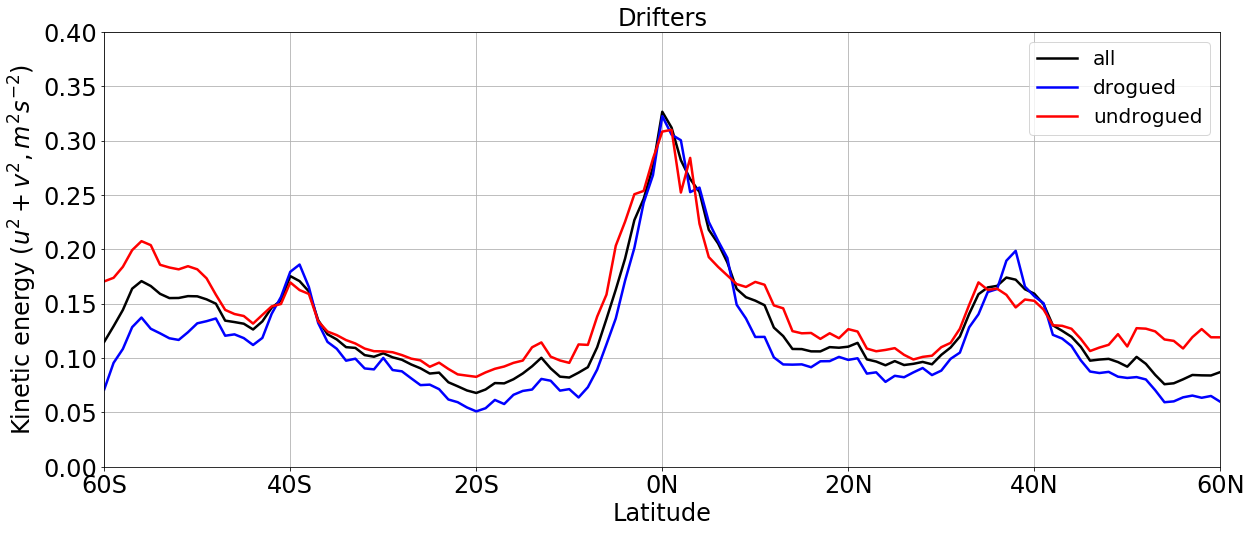

In [16]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


_______________
# 2. Only GPS-tracked drifters 

## separate drogued or undrogued

#### $KE = u^2 + v^2$

In [19]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed_GPS_only.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     25008*1
# mlon2: mean longitude over 60 days,    25008*1
# mdpth: mean water depth,               25008*1

# qd: drogued drifters,                  25008*1
# qmed200: median water depth > 200 m,   25008*1
# qu: undrogued drifters,                25008*1

# uv2: (u, v)                            25008*1440
# dpth2:                                 25008*1440

[('dpth2', <HDF5 dataset "dpth2": shape (25008, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (25008, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (25008, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (25008, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (25008, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (25008, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (25008, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (25008, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (25008, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (25008, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (25008, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (25008, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (25008, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (25008, 1), type "|u1">),
 ('u2_err', <HDF5 dataset "u2_err": sha

In [20]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 25008)>
array([  2.851229,   1.022867,  -1.890194, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [21]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 25008)>
array([267.180947, 258.853496, 249.391945, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [22]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 25008)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [23]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 25008)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [24]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 25008)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [25]:
mdpth = drifter_dataset['mdpth']
mdpth = np.array(mdpth)
mdpth = xr.DataArray(mdpth, dims=['mdpth', 'none'])
mdpth = xr.DataArray.squeeze(mdpth, dim='none')
mdpth = np.real(mdpth).rename('mdpth')
mdpth

<xarray.DataArray 'mdpth' (mdpth: 25008)>
array([-2481.856058, -3236.531319, -3926.650875, ..., -4722.161599,
       -4633.789814, -4684.155683])
Dimensions without coordinates: mdpth

In [26]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((25008, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

KE_drifters = (u_drifters**2 + v_drifters**2)

In [27]:
depth = drifter_dataset['dpth2']
depth = np.array(depth)

In [28]:
# Drifter Dataset (u+iv,lat,qd,time)
ds_GPS = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters),
                'depth': (['lat','time'],depth)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds_GPS)
print('\n data size: %.1f GB' %(ds_GPS.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 25008, time: 1440)
Coordinates:
  * lat          (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 24.73 ...
    lon          (lat) float64 267.2 258.9 249.4 320.8 319.6 318.0 318.0 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    qu           (lat) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    qmed200      (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.005215 0.009021 0.006992 0.005334 ...
    depth        (lat, time) float64 -2.571e+03 -2.574e+03 -2.578e+03 ...

 data size: 0.6 GB


## 2.2. KE

In [29]:
KE_drifters_qd_GPS = ds_GPS.KE_drifters.where((ds_GPS.qd==1) & (ds_GPS.depth<-500)).mean(dim=['time'])
KE_drifters_qd_GPS = np.real(KE_drifters_qd_GPS).rename('KE_drifters_qd_GPS')

KE_drifters_qu_GPS = ds_GPS.KE_drifters.where((ds_GPS.qu==1) & (ds_GPS.depth<-500)).mean(dim=['time'])
KE_drifters_qu_GPS = np.real(KE_drifters_qu_GPS).rename('KE_drifters_qu_GPS')

KE_drifters_all_GPS = ds_GPS.KE_drifters.where(ds_GPS.depth<-500).mean(dim=['time'])
KE_drifters_all_GPS = np.real(KE_drifters_all_GPS).rename('KE_drifters_all_GPS')

In [30]:
E_drifters_qd_GPS = KE_drifters_qd_GPS.groupby_bins(KE_drifters_qd_GPS.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd_GPS = E_drifters_qd_GPS.load()

E_drifters_qu_GPS = KE_drifters_qu_GPS.groupby_bins(KE_drifters_qu_GPS.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu_GPS = E_drifters_qu_GPS.load()

E_drifters_all_GPS = KE_drifters_all_GPS.groupby_bins(KE_drifters_all_GPS.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all_GPS = E_drifters_all_GPS.load()

Text(0.5,1,'GPS-tracked Drifters')

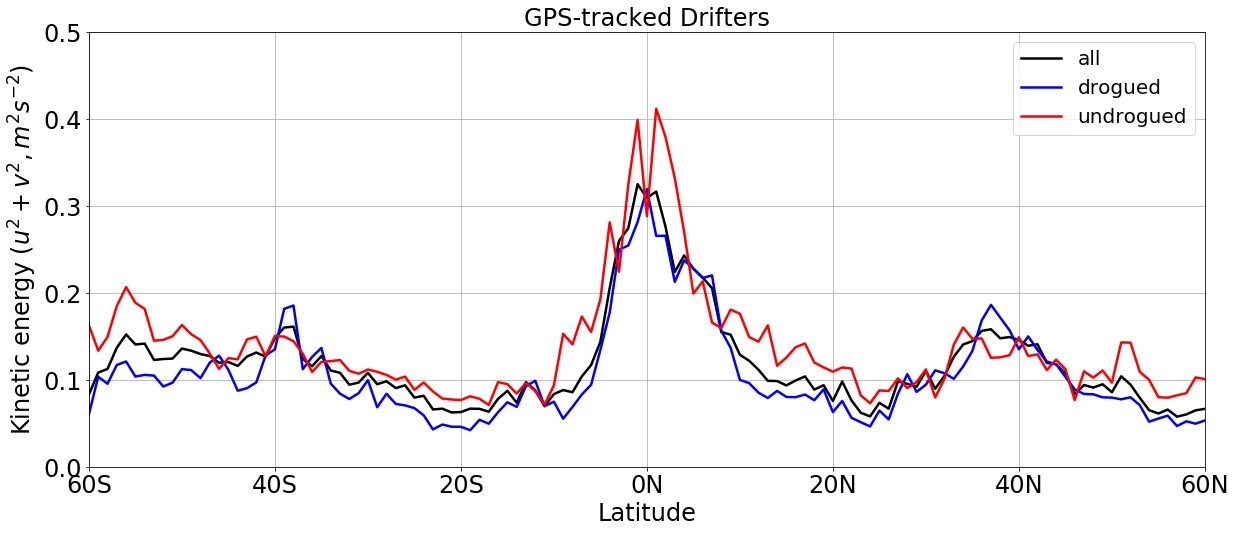

In [31]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all_GPS.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd_GPS.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu_GPS.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.5])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('GPS-tracked Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


_______________
# 3. Argos-tracked drifters 

## separate drogued and undrogued 

#### $KE = u^2 + v^2$

In [32]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed_Argos_only.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     25008*1
# mlon2: mean longitude over 60 days,    25008*1
# mdpth: mean water depth,               25008*1

# qd: drogued drifters,                  25008*1
# qmed200: median water depth > 200 m,   25008*1
# qu: undrogued drifters,                25008*1

# uv2: (u, v)                            25008*1440
# dpth2:                                 25008*1440

[('dpth2', <HDF5 dataset "dpth2": shape (132970, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (132970, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (132970, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (132970, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (132970, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (132970, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (132970, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (132970, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (132970, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (132970, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (132970, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (132970, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (132970, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (132970, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [33]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 132970)>
array([ 44.219853,  44.908928,  44.856863, ..., -12.761236, -12.266537,
       -12.920261])
Dimensions without coordinates: lat

In [34]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 132970)>
array([307.992707, 306.962722, 305.597501, ..., 186.569928, 185.446468,
       183.725235])
Dimensions without coordinates: lon

In [35]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 132970)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [36]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 132970)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [37]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 132970)>
array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [38]:
mdpth = drifter_dataset['mdpth']
mdpth = np.array(mdpth)
mdpth = xr.DataArray(mdpth, dims=['mdpth', 'none'])
mdpth = xr.DataArray.squeeze(mdpth, dim='none')
mdpth = np.real(mdpth).rename('mdpth')
mdpth

<xarray.DataArray 'mdpth' (mdpth: 132970)>
array([ -193.07666 ,   -78.65568 ,  -800.508745, ..., -4274.524006,
       -4004.953812, -3221.885254])
Dimensions without coordinates: mdpth

In [39]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((132970, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

KE_drifters = (u_drifters**2 + v_drifters**2)

In [40]:
depth = drifter_dataset['dpth2']
depth = np.array(depth)

In [41]:
# Drifter Dataset (u+iv,lat,qd,time)
ds_Argos = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters),
                'depth': (['lat','time'],depth)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds_GPS)
print('\n data size: %.1f GB' %(ds_GPS.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 25008, time: 1440)
Coordinates:
  * lat          (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 24.73 ...
    lon          (lat) float64 267.2 258.9 249.4 320.8 319.6 318.0 318.0 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    qu           (lat) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    qmed200      (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.005215 0.009021 0.006992 0.005334 ...
    depth        (lat, time) float64 -2.571e+03 -2.574e+03 -2.578e+03 ...

 data size: 0.6 GB


## 3.2. KE

In [42]:
KE_drifters_qd_Argos = ds_Argos.KE_drifters.where((ds_Argos.qd==1) & (ds_Argos.depth<-500)).mean(dim=['time'])
KE_drifters_qd_Argos = np.real(KE_drifters_qd_Argos).rename('KE_drifters_qd_Argos')

KE_drifters_qu_Argos = ds_Argos.KE_drifters.where((ds_Argos.qu==1) & (ds_Argos.depth<-500)).mean(dim=['time'])
KE_drifters_qu_Argos = np.real(KE_drifters_qu_Argos).rename('KE_drifters_qu_Argos')

KE_drifters_all_Argos = ds_Argos.KE_drifters.where(ds_Argos.depth<-500).mean(dim=['time'])
KE_drifters_all_Argos = np.real(KE_drifters_all_Argos).rename('KE_drifters_all_Argos')

In [43]:
E_drifters_qd_Argos = KE_drifters_qd_Argos.groupby_bins(KE_drifters_qd_Argos.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd_Argos = E_drifters_qd_Argos.load()

E_drifters_qu_Argos = KE_drifters_qu_Argos.groupby_bins(KE_drifters_qu_Argos.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu_Argos = E_drifters_qu_Argos.load()

E_drifters_all_Argos = KE_drifters_all_Argos.groupby_bins(KE_drifters_all_Argos.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all_Argos = E_drifters_all_Argos.load()

Text(0.5,1,'Argos-tracked Drifters')

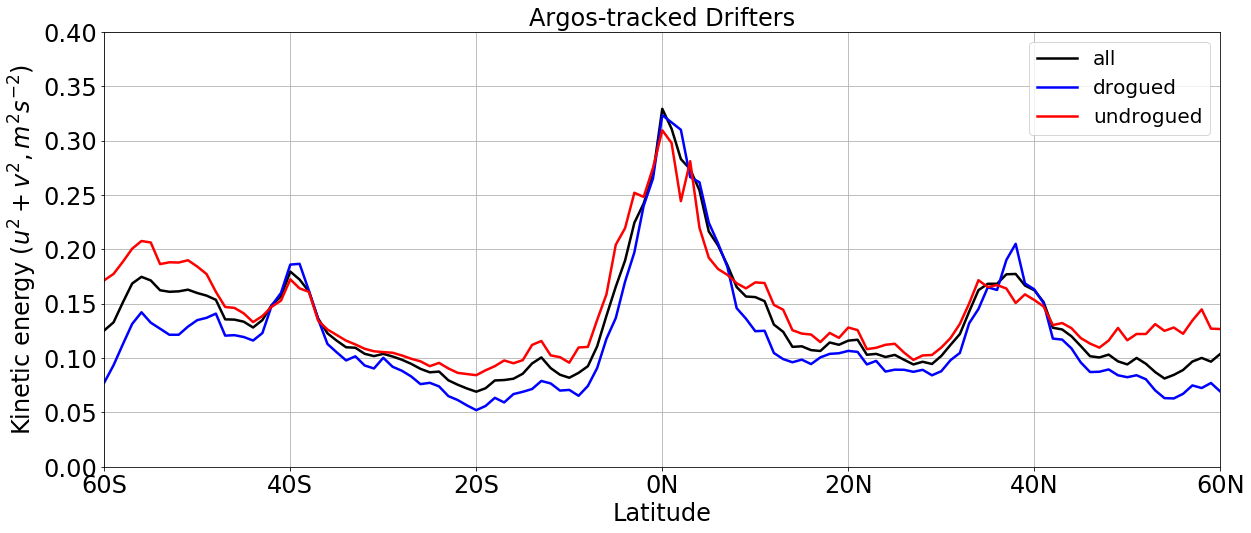

In [44]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all_Argos.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd_Argos.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu_Argos.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Argos-tracked Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


# 4. Comparison 

## Argos vs. GPS

Text(0.5,1,'Drifters')

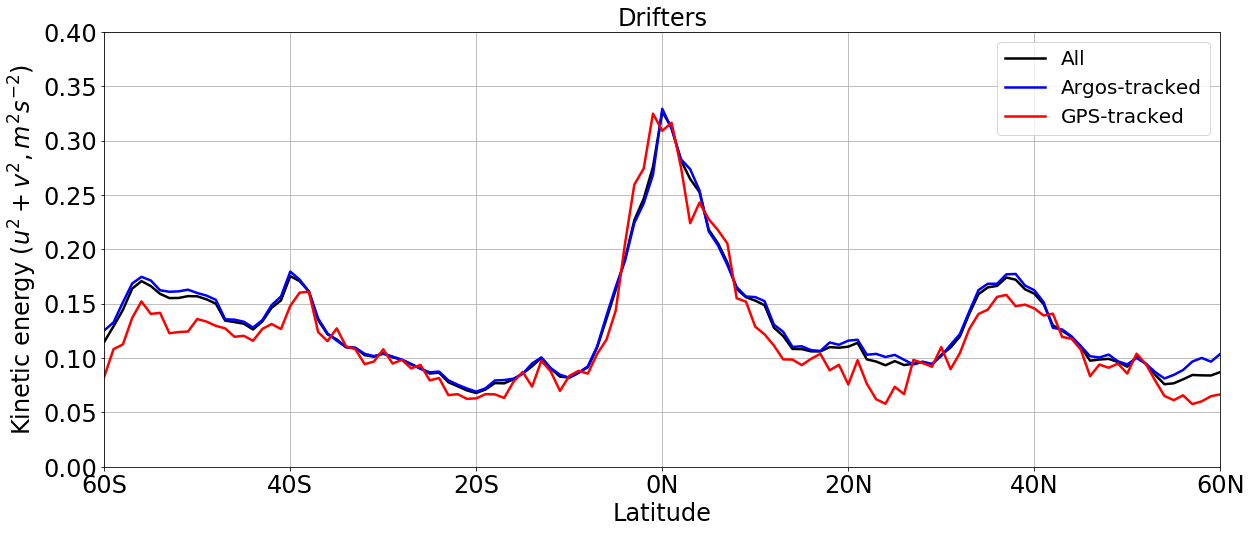

In [45]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['All','Argos-tracked','GPS-tracked']

E_drifters_all.plot(color='black', label=labels[0], linewidth=2.5)
E_drifters_all_Argos.plot(color='blue', label=labels[1], linewidth=2.5)
E_drifters_all_GPS.plot(color='red', label=labels[2], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


## Drogued vs. Undrogued

Text(0.5,1,'Drifters')

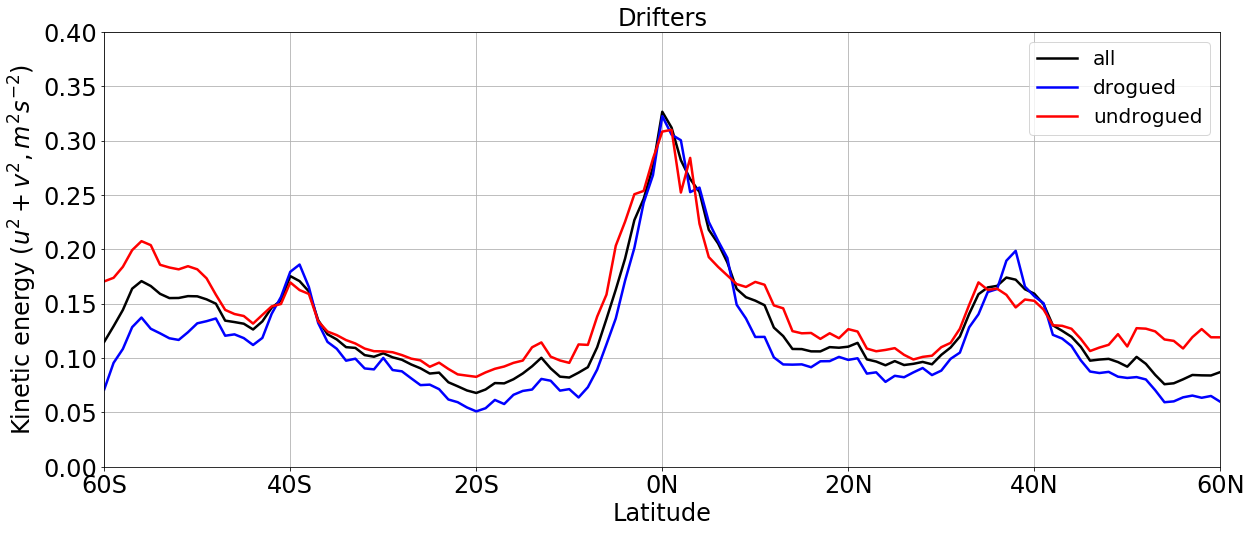

In [46]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


In [48]:
cluster.scheduler.close()

<Future finished result=None>